# BackTesting

A continuación algunas funciones básicas aplicadas a un método simplemente a modo de ejemplo ilustrativo

## Función para traer datos

### Para traer un solo ticker por vez

In [1]:
# pip install yfinance
import yfinance as yf
import pandas as pd

def getData(symbol, start='2000-01-01', interval='1d', end=None):
    data = yf.download(symbol, start=start, end=end, interval=interval, auto_adjust=True)
    return data

In [2]:
getData('GGAL')

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Volume
Date,,,,,
2000-07-25,16.33,16.58,15.65,16.35,126200
2000-07-26,16.11,16.41,16.06,16.35,28900
2000-07-27,16.35,16.47,16.23,16.35,61200
2000-07-28,16.41,16.41,16.00,16.23,146100
2000-07-31,16.35,16.52,15.76,16.52,178400
...,...,...,...,...,...
2020-09-02,10.40,10.42,9.86,10.11,1222100
2020-09-03,10.19,10.53,10.07,10.28,920300
2020-09-04,10.46,10.50,10.01,10.18,757800


### Para traer multiples tickers, batch requests etc

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [t for t in sp500_tickers if t not in ['BRK.B' ,'BF.B']]

In [3]:
def getDataM(listado, start='2000-01-01', interval='1d', end=None):
    data = yf.download(listado, start=start, end=end, interval=interval, auto_adjust=True)
    return data.swaplevel(i=1, j=0, axis=1)

In [4]:
df_sp500 = getDataM(sp500_tickers)

[*********************100%***********************]  503 of 503 downloaded


## Función para crear indicadores

In [5]:
def addSignal(data, fast=5, slow=20, rsi_q=14, buy_cr=0, buy_rsi=60, sell_cr= -5, sell_rsi=35):
    data['Variacion'] = data.Close.pct_change()*100
    data['Volatilidad'] = data.Variacion.rolling(250).std() * 250**0.5

    data['Cruce'] = (data.Close.rolling(fast).mean() /
                     data.Close.rolling(slow).mean() - 1) * 100

    dif = data['Close'].diff()
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1 / rsi_q).mean()
    ema_loss = loss.ewm(alpha=1 / rsi_q).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index
    data['rsi'] = rsi

    data['Señal'] = 'Sin Señal'
    comprar = (data.Cruce > buy_cr) & (data.rsi > buy_rsi)
    data.loc[comprar, 'Señal'] = 'Compra'

    vender = (data.Cruce < sell_cr) & (data.rsi < sell_rsi) 
    data.loc[vender, 'Señal'] = 'Venta'

    return data

## Función para armar tabla de acciones

In [6]:
def getActions(data, long_short='both'):
    
    # Una sola entrada y salida por vez
    actions = data.loc[data.Señal != 'Sin Señal', ['Close','Cruce','rsi','Señal']].copy()
    actions['Señal'] = np.where(actions.Señal != actions.Señal.shift(), actions.Señal,'Sin Señal')
    actions = actions.loc[actions.Señal != 'Sin Señal'].copy()    
    
    try:
        if long_short=='long':
            if actions.iloc[0,3]=='Venta':
                actions = actions.iloc[1:]
            if trades.iloc[-1,3]=='Compra':
                actions = actions.iloc[:-1]
        if long_short=='short':
            if actions.iloc[0,3]=='Compra':
                actions = actions.iloc[1:]
            if actions.iloc[-1,3]=='Venta':
                actions = actions.iloc[:-1]
    except:
        pass
            
    return actions

## Función para armar tabla de trades

In [7]:
def getTrades(actions, long_short='both'):
    trades = []
    cerrado = True
    t = {}
    for index, row in actions.iterrows():          
        if cerrado == True:
            t['fecha_in'] = index
            t['price_in'] = row['Close']
            if row['Señal']=='Venta':
                t['side'] = 'short'
            else:
                t['side'] = 'long'   
            cerrado = False
        else:
            t['price_out'] = row['Close']
            t['fecha_out'] = index
            trades.append(t)
            cerrado = True
            t = {}
            t['fecha_in'] = index
            t['price_in'] = row['Close']
            if row['Señal']=='Venta':
                t['side'] = 'short'
            else:
                t['side'] = 'long'   
            cerrado = False
    res = pd.DataFrame(trades)
    res['yield'] = np.where(res.side=='long', res.price_out/res.price_in-1, res.price_in/res.price_out-1 )
    res['dias'] = (res.fecha_out - res.fecha_in).dt.days
    
    if long_short=='long':
        df = res.loc[res.side=='long']
        
    if long_short=='short':
        df = res.loc[res.side=='short']
            
    return res
    

## Funcion de métricas de señales

In [8]:
def getSignalMetrics(df):
    df_copia = df.copy()

    # El shift(-1) es para usar las variaciones luego de las señales, ojo ahi
    df_copia['Señal'] = df_copia['Señal'].shift(-1) 
    
    #En caso de querer tomar como señales valores sin señal iterpolando, descomentar sig
    #df_copia['Señal'] = np.where(df_copia.Señal=='Sin Señal',np.nan, df_copia.Señal)
    #df_copia['Señal']  = df_copia['Señal'].fillna(method='backfill')
    
    medias = df_copia.groupby('Señal').mean()
    
    res = pd.DataFrame(medias.Volatilidad)
    res.loc['Total'] = df_copia.Volatilidad.mean()
    
    res.loc[:,'Variacion'] = medias.Variacion
    res.loc['Total', 'Variacion'] = df_copia.Variacion.mean()

    res.loc[:,'Cantidad'] = df_copia.groupby('Señal').size()
    res.loc['Total', 'Cantidad'] = len(df_copia)

    res.loc[:,'Volumen'] = medias.Volume
    res.loc['Total', 'Volumen'] = df_copia.Volume.mean()

    res.loc[:,'TiempoIn'] = round(res.Cantidad / res.Cantidad.Total,4)*100

    return res

## Función de métricas de trades

In [9]:
def getTradesMetrics(trades):
    trades['factor'] =  trades['yield']+1
    longs = trades.loc[trades.side=='long']
    shorts = trades.loc[trades.side=='short']
    res = pd.DataFrame(index=['Shorts','Longs','Total'])
        
    res.loc['Longs', 'Yield %'] = (longs.factor.prod()-1)*100
    res.loc['Shorts', 'Yield %']  = (shorts.factor.prod()-1)*100
    res.loc['Total', 'Yield %']  = (trades.factor.prod()-1)*100
    
    res.loc['Longs', 'Dias']  = longs.dias.sum()
    res.loc['Shorts', 'Dias'] = shorts.dias.sum()
    res.loc['Total', 'Dias'] = trades.dias.sum()

    res.loc['Longs', 'TIR %'] = ((res.loc['Longs','Yield %']/100+1)**(1/(res.loc['Longs', 'Dias'] /365))-1)*100
    res.loc['Shorts', 'TIR %'] = ((res.loc['Shorts','Yield %']/100+1)**(1/(res.loc['Shorts', 'Dias'] /365))-1)*100
    res.loc['Total', 'TIR %'] = ((res.loc['Total','Yield %']/100+1)**(1/(res.loc['Total', 'Dias'] /365))-1)*100

    return res.round(2)

In [29]:
# Traigo data de API
data = getData('AAPL')

# Armo mis indicadores
df = addSignal(data,fast=5, slow=20, rsi_q=14, buy_cr=0, buy_rsi=70, sell_cr=0, sell_rsi=35)

# Decido cuando comprar o vender
actions = getActions(df)

# Armo tabla de trades
trades = getTrades(actions)

# Reporte de metricas generales de cada señal
signalMetrics = getSignalMetrics(df)

# Reporte de métricas de trades
tradesMetrics = getTradesMetrics(trades)

[*********************100%***********************]  1 of 1 downloaded


In [34]:
signalMetrics

,Volatilidad,Variacion,Cantidad,Volumen,TiempoIn
Señal,,,,,
Compra,32.880777,0.988826,760.0,4.653048e+08,14.60
Sin Señal,37.612244,0.119560,4097.0,4.293825e+08,78.71
Venta,38.306354,-1.626770,347.0,6.588155e+08,6.67
Total,36.932433,0.130808,5205.0,4.498730e+08,100.00


In [35]:
tradesMetrics

,Yield %,Dias,TIR %
Shorts,-71.41,2907.0,-14.55
Longs,2471.15,4312.0,31.63
Total,635.16,7219.0,10.61


In [30]:
df

,Open,High,Low,Close,Volume,Variacion,Volatilidad,Cruce,rsi,Señal
Date,,,,,,,,,,
2000-01-03,0.81,0.87,0.78,0.86,535796800,NaN,NaN,NaN,NaN,Sin Señal
2000-01-04,0.84,0.85,0.78,0.79,512377600,-8.139535,NaN,NaN,0.000000,Sin Señal
2000-01-05,0.80,0.85,0.79,0.80,778321600,1.265823,NaN,NaN,13.333333,Sin Señal
2000-01-06,0.82,0.83,0.73,0.73,767972800,-8.750000,NaN,NaN,6.649616,Sin Señal
2000-01-07,0.74,0.78,0.74,0.77,460734400,5.479452,NaN,NaN,28.657345,Sin Señal
...,...,...,...,...,...,...,...,...,...,...
2020-09-02,137.59,137.98,127.00,131.40,200119000,-2.071844,41.989857,7.405772,74.755275,Compra
2020-09-03,126.91,128.84,120.50,120.88,257599600,-8.006088,42.823074,6.399136,54.894649,Sin Señal
2020-09-04,120.07,123.70,110.89,120.96,332607200,0.066181,42.816524,5.328396,54.992574,Sin Señal


In [31]:
df.groupby('Señal').size()

Señal
Compra        760
Sin Señal    4098
Venta         347
dtype: int64

In [32]:
actions

,Close,Cruce,rsi,Señal
Date,,,,
2000-08-30,0.92,13.489550,70.192183,Compra
2000-09-29,0.40,-16.144019,24.394970,Venta
2001-01-23,0.32,12.859885,70.949514,Compra
2001-05-30,0.31,-6.043956,31.401389,Venta
2001-12-05,0.37,8.333333,73.658205,Compra
2002-05-06,0.35,-3.320053,34.653798,Venta
2002-10-30,0.25,6.430155,73.486476,Compra
2002-12-18,0.22,-3.184713,34.395160,Venta
2003-05-05,0.25,5.607477,76.077372,Compra


In [33]:
trades

,fecha_in,price_in,side,price_out,fecha_out,yield,dias,factor
0,2000-08-30,0.92,long,0.40,2000-09-29,-0.565217,30,0.434783
1,2000-09-29,0.40,short,0.32,2001-01-23,0.250000,116,1.250000
2,2001-01-23,0.32,long,0.31,2001-05-30,-0.031250,127,0.968750
3,2001-05-30,0.31,short,0.37,2001-12-05,-0.162162,189,0.837838
4,2001-12-05,0.37,long,0.35,2002-05-06,-0.054054,152,0.945946
5,2002-05-06,0.35,short,0.25,2002-10-30,0.400000,177,1.400000
6,2002-10-30,0.25,long,0.22,2002-12-18,-0.120000,49,0.880000
7,2002-12-18,0.22,short,0.25,2003-05-05,-0.120000,138,0.880000
8,2003-05-05,0.25,long,1.15,2005-04-14,3.600000,710,4.600000
9,2005-04-14,1.15,short,1.33,2005-07-19,-0.135338,96,0.864662


In [45]:
trades.groupby(trades.fecha_in.dt.year).factor.prod()-1

fecha_in
2000   -0.545132
2001   -0.232218
2002    0.084160
2003    3.600000
2005    0.352253
2006   -0.014098
2007   -0.086175
2008    0.485165
2009    1.228916
2010    0.070280
2011    0.235861
2012    0.053896
2013   -0.173319
2014    0.008715
2015    0.115899
2016   -0.161481
2017   -0.017636
2018   -0.004731
2019   -0.049596
2020   -0.133325
Name: factor, dtype: float64

In [33]:
tradesMetrics

,Yield %,Dias,TIR %
Shorts,-76.07,3019.0,-15.88
Longs,2471.15,4312.0,31.63
Total,515.30,7331.0,9.47


In [34]:
signalMetrics

,Volatilidad,Variacion,Cantidad,Volumen,TiempoIn
Señal,,,,,
Compra,32.880777,0.988826,760.0,4.653048e+08,14.60
Sin Señal,37.610786,0.121233,4096.0,4.294311e+08,78.71
Venta,38.306354,-1.626770,347.0,6.588155e+08,6.67
Total,36.931116,0.130067,5204.0,4.499271e+08,100.00


# Contenidos de un backtest

* PreBackTest (Etapa de Research)
    * Armado de tablas de indicadores potenciales
    * Planteo de "Racional" o Hipótesis de trabajo
    * Análisis de correlación
        * Regresiones inputs/forwards
        * Algos de clasificacion o probabilidades de suba o baja en funcion de inputs
    * Tabla de posibles trades pasados el racional de trading
    * Tabla de resultados o reporting básico
        * % de trades positivos y negativos
        * Esperanza matemática del método
        * Tiempo comprado / libre
        
        
* Backtest básico
    * Trades en un grupo de activos, en un rango de parametros
    * Tabla de resultados intermedia
        * Resultados año a año
        * Comparación con el buy&Hold
        * Comparación con el banchmark
        * Ratios de riesgo (Sharpe, Sortino, etc)
        


* Análisis de sensibilidad
    * Parametrización de variables
    * Cambio de indicadores
    * Uso de grupos de control
    


* Análisis de portabilidad
    * Riesgo de overfiting
    * Cruce y armado de matrices de resultados
    * Matrices de correlacion cross mkt
    * Matrices de correlacion cross time-frame
    * Clusterizacion por régimenes (volatilidad, épocas, ciclos etc)
    
    
* Backtest Avanzado
    * Manejo de posición/riesgo, exposición óptima (Kelly, Montecarlo etc)
    * Factibilidad técnica (volúmenes, liquidez, spreads, fallas, tiempos etc)


# Ejemplo real del Item "BackTest Básico"

Es un caso real de la parte básica de un front que hice hace unos años para un cliente

<img src='imagenes/backtest.png'>

# Objetivos principales de cada etapa

1- PreBackTest (Etapa de Research)

    El objetivo es plantear todo tipo de idea posible, verificar antes que nada la correlación entre los inputs planteados y la reacción del mercado, etc
    
    La idea es plantear la mayor cantidad de hipótesis posibles, ser amplio en la visión y riguroso en que sirve y que no sirve, ante la duda dejar para validar mas adelante

        
        
2- Backtest básico

    El objetivo principal es empezar a validar en forma rápida la conveniencia de aplicar un método algoritmico, tanto por el riesgo asumido como contra eel benchmark de su mercado y la variabilidad en diferentes contextos, epocas etc..
    
        
3- Análisis de sensibilidad

    El objetivo principal de esta etapa es el análisis de cada parámetro del sistema, ver como varían los resultados variando todo tipo de parámetro, donde aumentan o disminuyen la cantidad de señales, de eventos positivos, negativos, extremos, medios, largos, cortos, etc. 
    
    Claramente es la etapa mas abierta que puede dar pie a volver a la etapa de research y empezar a replantear indicadores


4- Análisis de portabilidad

    Es el anteúltimo filtro del método es la prueba de fuego al overfiting, aque se pone a prueba el método frente a diferentes mercados, a diferentes timeframes, a diferentes activos o grupos de activos etc, obviamente no necesariamente tiene que ser portable a todo, pero tampoco puede ser un método aplicable a un solo activo en un solo timeframe en una sola época
    
    Si bien siempre hay variabilidad, un método bien robusto se mueve en rangos acotados, es decir no puede dar lo contrario en un activo que en otro, puede performar un poco mejor un poco peor, etc, de hecho si construyen una distribucion de rendimientos a varios activos, mientras menor desvio del rendimiento mas robusto el método o mas portable entre activos
    
    Es muy util en este punto los algos de clusterizacion para ver comportamiento en diferentes clusters (que pueden ser régimenes de volatilidad, volumen, tendencias, etc..)
    
    
5- Backtest Avanzado
    
    Esta es la etapa final, aquí se valida la viabilidad en cuanto a liquidez, costo transaccional, spreads, posibles fallas del mercado, apis, tiempos, volúmenes, reglamentaciones, etc
    
    También se valida la exposición real y el manejo de posicion buscando un tamaño de posición óptima al riesgo a asumir, esto puede estimarse via montecarlo o modelarse con criterios como kelly

# Analisis de sensibilidad muy básico (a modo de ejemplo)

Lo que muestro en estas lineas es solo conceptual solo para mostrar alguna idea de referencia

Creo que no hace falta aclarar pero por las dudas: "NO HACER ANALISIS PARCIAL"

O sea, si buscan un "rsi_q" optimo, y luego un "fast", "slow" optimos para el cruce usando el rsi_optimo dado en el punto anterior, es de esperar que luego para ese nuevo cruce, el "rsi_q" optimo ahora cambie.. y asi.. debe contemplarse todo junto, yo les myestro cosas aisladas para comprender la idea

In [49]:
# Traigo data de API
data = getData('GGAL')

[*********************100%***********************]  1 of 1 downloaded


## Ejemplo: Sensibilidad RSI

In [56]:
l = []
for i in range(5,50):
    df = addSignal(data,fast=10, slow=30, rsi_q=i, buy_cr=0, buy_rsi=70, sell_cr=0, sell_rsi=35)
    actions = getActions(df)
    trades = getTrades(actions)
    tradesMetrics = getTradesMetrics(trades)
    l.append(tradesMetrics['TIR %'])

sens_rsi = pd.DataFrame(l, index=(range(5,50)))

In [57]:
sens_rsi

,Shorts,Longs,Total
5,72.72,65.46,69.05
6,76.12,74.20,75.19
7,65.39,75.79,70.07
8,57.01,68.08,61.89
9,54.41,66.89,59.82
10,48.96,68.06,56.66
11,46.13,66.13,54.04
12,51.32,66.71,57.76
13,45.53,57.94,50.75
14,43.70,48.34,45.80


In [58]:
sens_rsi['Total'].idxmax()

6

<AxesSubplot:ylabel='TIR % para cada "i" de la config RSI'>

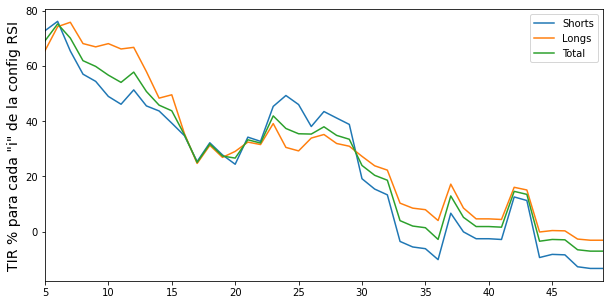

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel('TIR % para cada "i" de la config RSI', fontsize=14)

sens_rsi.plot(ax=ax)

## Ejemplo: Sensibilidad cruce

In [52]:
l = []
for i in range(10,50):
    fast = i
    slow = i * 3

    df = addSignal(data,fast=fast, slow=slow, rsi_q=6, buy_cr=0, buy_rsi=70, sell_cr=0, sell_rsi=35)
    actions = getActions(df)
    trades = getTrades(actions)
    tradesMetrics = getTradesMetrics(trades)
    l.append(tradesMetrics['TIR %'])

sens_sma = pd.DataFrame(l, index=(range(10,50)))

In [55]:
sens_sma['Shorts'].idxmax()

26

<AxesSubplot:ylabel='TIR % para cada "i" cruce = ( i, 3i )'>

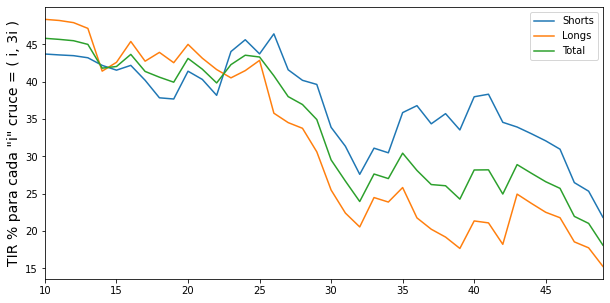

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel('TIR % para cada "i" cruce = ( i, 3i )', fontsize=14)
sens_sma.plot(ax=ax)

## Ejemplo Sensibilidad por montecarlo multivariable

In [20]:
import random

In [60]:
%%time

l = []
for i in range(100):
    random_f = random.randrange(35,50)
    random_s = int(random_f * (random.random()+1))+1
    random_rsi = random.randrange(10,30)

    df = addSignal(data,fast=random_f, slow=random_s, rsi_q=random_rsi, buy_cr=0, buy_rsi=70, sell_cr=0, sell_rsi=35)
    actions = getActions(df)
    trades = getTrades(actions)
    tradesMetrics = getTradesMetrics(trades)
    r = tradesMetrics['TIR %']
    r['medias'] = (random_f,random_s)
    r['rsi'] = (random_rsi)
    l.append(r)

results = pd.DataFrame(l, index=(range(100)))

Wall time: 8.18 s


In [61]:
results.sort_values('Total', ascending=False)

,Shorts,Longs,Total,medias,rsi
12,41.50,40.35,40.93,"(41, 51)",14
21,63.59,27.62,39.54,"(47, 68)",23
73,55.36,32.71,39.26,"(47, 67)",26
14,36.79,41.65,38.99,"(39, 46)",11
33,35.27,43.26,38.73,"(37, 42)",14
...,...,...,...,...,...
88,19.95,7.68,13.30,"(46, 88)",12
43,17.14,8.44,12.40,"(45, 85)",16
61,16.32,8.31,12.16,"(43, 85)",14
72,12.80,11.19,11.98,"(41, 66)",17


<AxesSubplot:>

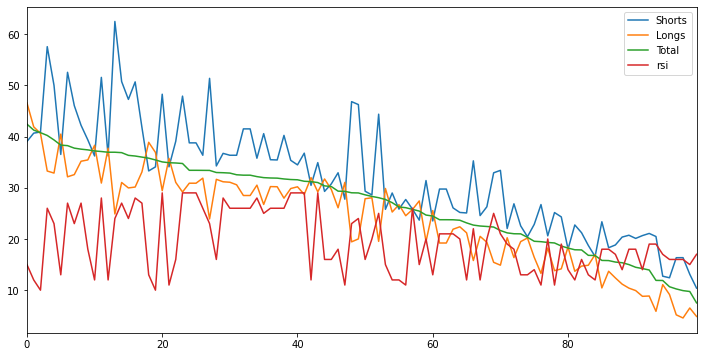

In [23]:
results.sort_values('Total', ascending=False).reset_index(drop=True).plot(figsize=(12,6))

# Analisis de Portabilidad Básico

En este caso recorro el mismo método para los 500 del SP500 siempre con la misma parametrizacion para todos, la idea es ver la coherencia o no de los resultados

In [62]:
l = []
s = "\n"+ "*"*50 + "\n"

for ticker in sp500_tickers:
    try:
        data = df_sp500[ticker].copy()
        df = addSignal(data,fast=20, slow=40, rsi_q=14, buy_cr=0, buy_rsi=70, sell_cr=0, sell_rsi=35)
        actions = getActions(df)
        if len(actions)>1:
            trades = getTrades(actions)
            if len(trades)>1:
                tradesMetrics = getTradesMetrics(trades)
                r = tradesMetrics['TIR %']
                r['ticker'] = (ticker)
                l.append(r)
                print(ticker, end='..')
            else:
                print(s,"No hay trades para",ticker,s)
        else:
            print(s,"No hay acciones para",ticker,s)

    except:
        print(s,"Error con",ticker,s)

results_df = pd.DataFrame(l).set_index('ticker')

MMM..ABT..ABBV..ABMD..ACN..ATVI..ADBE..AMD..AAP..AES..AFL..A..APD..AKAM..ALK..ALB..ARE..ALXN..ALGN..ALLE..LNT..ALL..GOOGL..GOOG..MO..AMZN..AMCR..AEE..AAL..AEP..AXP..AIG..AMT..AWK..AMP..ABC..AME..AMGN..APH..ADI..ANSS..ANTM..AON..AOS..APA..AIV..AAPL..AMAT..APTV..ADM..ANET..AJG..AIZ..T..ATO..ADSK..ADP..AZO..AVB..AVY..BKR..BLL..BAC..BK..BAX..BDX..BBY..BIO..BIIB..BLK..BA..BKNG..BWA..BXP..BSX..BMY..AVGO..BR..CHRW..COG..CDNS..CPB..COF..CAH..KMX..CCL..
**************************************************
 No hay acciones para CARR 
**************************************************

CAT..CBOE..CBRE..CDW..CE..CNC..CNP..CTL..CERN..CF..SCHW..CHTR..CVX..CMG..CB..CHD..CI..CINF..CTAS..CSCO..C..CFG..CTXS..CLX..CME..CMS..KO..CTSH..CL..CMCSA..CMA..CAG..CXO..COP..ED..STZ..COO..CPRT..GLW..CTVA..COST..COTY..CCI..CSX..CMI..CVS..DHI..DHR..DRI..DVA..DE..DAL..XRAY..DVN..DXCM..FANG..DLR..DFS..DISCA..DISCK..DISH..DG..DLTR..D..DPZ..DOV..DOW..DTE..DUK..DRE..DD..DXC..ETFC..EMN..ETN..EBAY..ECL..EIX..EW..EA..EMR..ETR.

In [25]:
results_df

,Shorts,Longs,Total
ticker,,,
MMM,-15.46,-0.17,-8.94
ABT,-21.18,4.15,-7.97
ABBV,-12.49,21.34,2.19
ABMD,-9.80,13.59,0.66
ACN,-20.04,8.02,-5.37
...,...,...,...
YUM,-22.36,9.39,-6.30
ZBRA,-18.29,2.68,-8.27
ZBH,-5.11,10.02,2.66


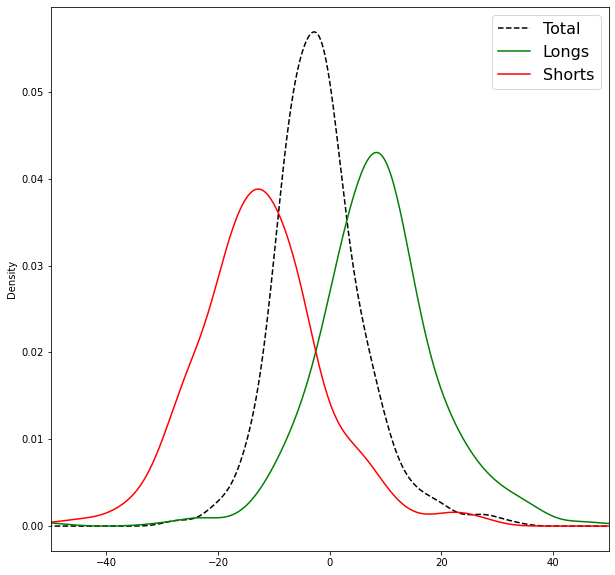

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

results_df.Total.plot(kind='kde', xlim=(-50,50), c='k', ls='--', ax=ax, label='Total')
results_df.Longs.plot(kind='kde', xlim=(-50,50), c= 'g', ax=ax, label='Longs')
results_df.Shorts.plot(kind='kde', xlim=(-50,50), c= 'r', ax=ax, label='Shorts')
ax.legend(fontsize=16)